# Temperature Test 2

In [1]:
import os, astropy, h5py
from disktemperature   import tmid
from io                import BytesIO
from zipfile           import ZipFile
from urllib            import request
from radmc3dPy         import analyze

import matplotlib.pyplot as plt
import numpy             as np
import astropy.constants as c
import astropy.units     as u

pi    = np.pi
AU    = u.au.to('cm')
R_sun = c.R_sun.cgs.value
M_sun = c.M_sun.cgs.value
L_sun = c.L_sun.cgs.value
T_sun = (L_sun/(4*pi*R_sun**2*c.sigma_sb.cgs.value))**0.25

%matplotlib inline
plt.style.use(['seaborn-dark',{'axes.grid': True,'font.size':18,'figure.figsize':(10,8),'lines.linewidth':2}]);

In [2]:
dpath = 'radmc_data'
url   = 'https://github.com/birnstiel/Birnstiel2015_scripts/archive/master.zip'
#
# download
#
if not os.path.isdir(dpath):
    os.mkdir(dpath)
    res = request.urlopen(url)
    zipfile= ZipFile(BytesIO(res.read()))
    for i in zipfile.namelist():
        if 'data_disklifetime' in i or 'data.hdf5' in i:
            if not i.endswith(os.sep):
                with open(os.path.join(dpath,os.path.basename(i)), 'wb') as f:
                    f.write(zipfile.read(i))

In [3]:
# fix wavelength grid for radmc3dPy
with open(os.path.join(dpath,'wavelength_micron.inp')) as f:
    wl = [w for w in f.readlines() if w.strip()!='']
with open(os.path.join(dpath,'wavelength_micron.inp'),'w') as f:
    f.writelines(wl)

In [4]:
# rename gas density file for radmc3dPy
import shutil
shutil.copy('radmc_data/gas_density.inp','radmc_data/numberdens_gas.inp')

'radmc_data/numberdens_gas.inp'

## Load RADMC-3D data

In [5]:
pwd = os.getcwd()
try:
    os.chdir(dpath)
    data = analyze.readData(ddens=True,dtemp=True,gdens=True,binary=False,ispec='gas')   
finally:
    os.chdir(pwd)
#
# read particle sizes
#
na, = data.rhodust[0,0,0,:].shape
a = h5py.File(os.path.join(dpath,'data.hdf5'))['a'][()][:na]
#
# gas density
#
rhog = data.ndens_mol[:,:,0,0]

Reading wavelength_micron.inp
Reading dust density
Reading dust temperature
Reading gas density (numberdens_gas.inp)


# Plot mid-plane temperature

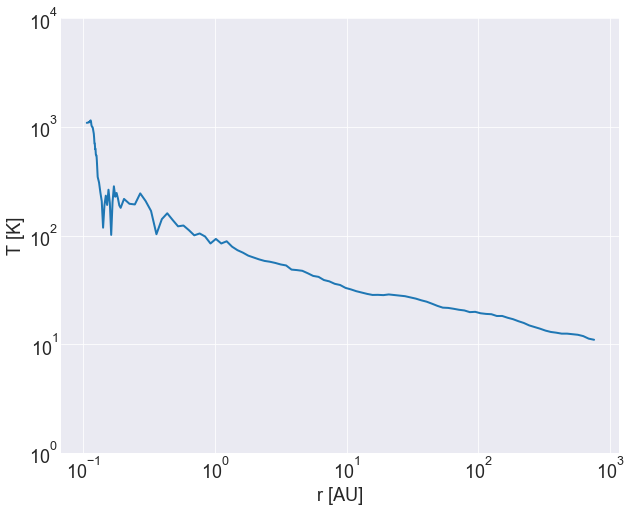

In [6]:
f,ax = plt.subplots(figsize=(10,8))
l,=ax.loglog(data.grid.x/AU,data.dusttemp[:,-1,0,0])

ax.set_ylim(1e0,1e4)
ax.set_ylabel('T [K]')
ax.set_xlabel('r [AU]');

# Read the dust data

Define a disk model from the diskevol and RADMC-3D result.

In [7]:
from pydisk1D import pydisk1D
dd = pydisk1D('/Users/birnstiel/Dropbox/projects/scattered_light_gaps/paper_working_copy/scripts/sim_data/data_disklifetime_mstar07_mratio1_rc200_vf10_alpha3_static_243.hdf5')

loading from /Users/birnstiel/Dropbox/projects/scattered_light_gaps/paper_working_copy/scripts/sim_data/data_disklifetime_mstar07_mratio1_rc200_vf10_alpha3_static_243.hdf5 ... Done!


In [8]:
with h5py.File(dpath+os.sep+'data.hdf5') as f:
    M_star = f['M_star'][()]
    a      = f['a'][()]
    alpha  = f['alpha'][()]
    r      = f['r'][()]
    sig_g  = f['sig_g'][()]
    sig_d  = f['sig_da'][()]
    
sig_d_t = sig_d.sum(0)
M_star  = dd.nml['M_STAR_INITIAL']*M_sun
R_star  = dd.nml['R_STAR']
T_star  = dd.nml['T_STAR']

if not np.all(np.isclose(r,dd.x)):
    import warnings
    warnings.warn('pydisk1d data and RADMC data not corresponding')

Initialize the mid-plane temperature model.

In [9]:
self = tmid.tmid(_amin=a[0],_amax=a[-1],_na=len(a),_nl=60,T_star=T_star,R_star=R_star,M_star=M_star)

Mie ... Done!


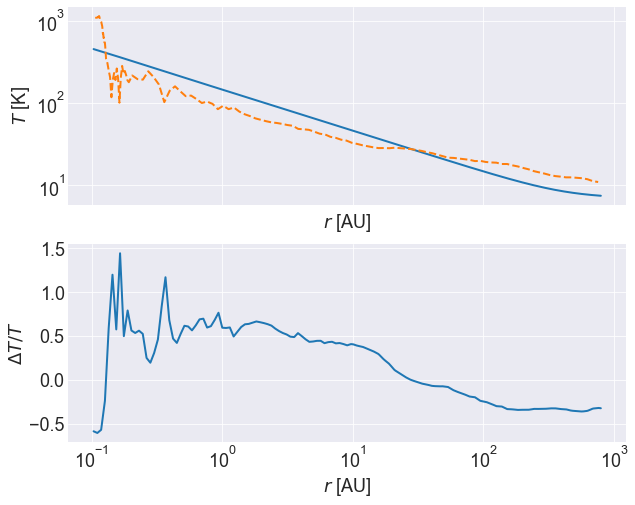

In [10]:
f,(ax1,ax2) = plt.subplots(2,1,sharex=True)
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

# calculate & plot temperature

T = self.get_t_mid(r,sig_g,sig_d,alpha*np.ones(r.shape))

ax1.loglog(r/AU,T)
ax1.loglog(data.grid.x/AU,data.dusttemp[:,-1,0,0],'--')
ax1.set_xlabel('$r$ [AU]')
ax1.set_ylabel('$T$ [K]')

ax2.semilogx(r/AU,T/np.interp(r,data.grid.x,data.dusttemp[:,-1,0,0])-1)
ax2.set_xlabel('$r$ [AU]')
ax2.set_ylabel('$\Delta T/T$');

# Compare the temperature after some iteration

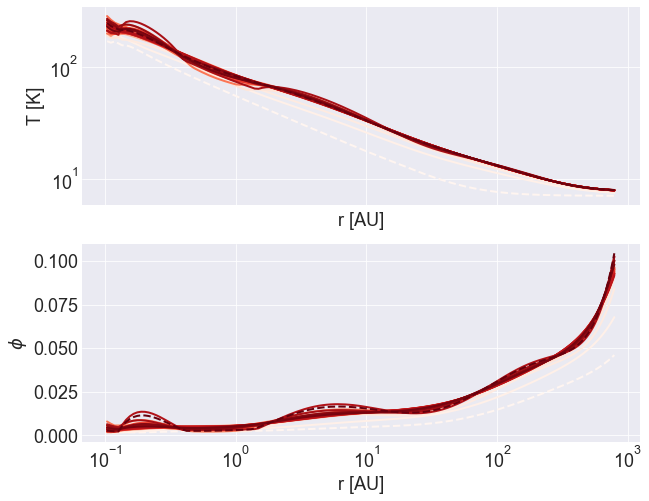

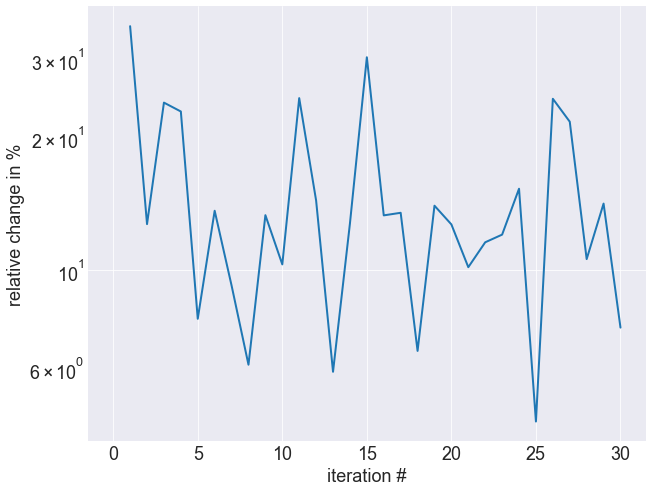

In [11]:
from constants import Grav, k_b, mu, m_p
phi      = 0.01
om       = np.sqrt(Grav*M_star/r**3)
T_of_phi = lambda phi: self.get_t_mid(r,sig_g,sig_d,alpha*np.ones(r.shape),phi=phi)
H_of_T   = lambda T:   np.sqrt(T*(k_b/mu/m_p))/om
T        = tmid.temperature_iterator(r,T_of_phi,H_of_T,do_plot=True,phi_min=0.001)

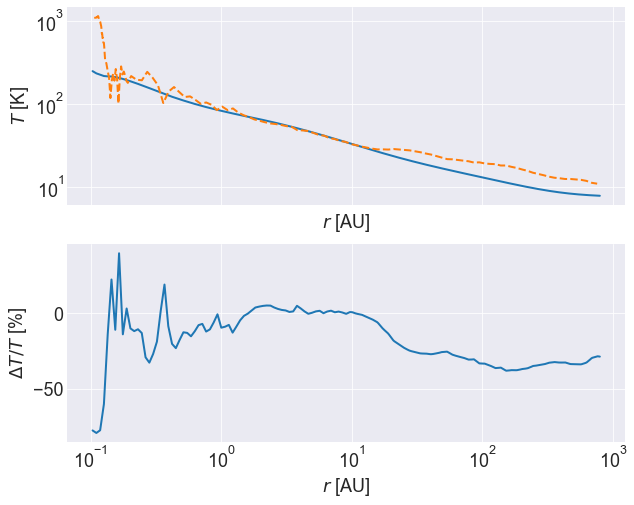

In [12]:
f,(ax1,ax2) = plt.subplots(2,1,sharex=True)

ax1.loglog(r/AU,T)
ax1.loglog(data.grid.x/AU,data.dusttemp[:,-1,0,0],'--')
ax1.set_xlabel('$r$ [AU]')
ax1.set_ylabel('$T$ [K]')

ax2.semilogx(r/AU,(T/np.interp(r,data.grid.x,data.dusttemp[:,-1,0,0])-1)*100)
ax2.set_xlabel('$r$ [AU]')
ax2.set_ylabel('$\Delta T/T$ [%]');